<a href="https://colab.research.google.com/github/Efefefef/IANNwTF-UniOsnabrueck/blob/main/Homework03_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

In [11]:
# Visualization function
def visualization(train_losses , train_accuracies , test_losses , test_accuracies):
    plt.figure()
    line1 , = plt.plot(train_losses , "b-")
    line2 , = plt.plot(test_losses , "r-") 
    line3 , = plt.plot(train_accuracies , "b:")
    line4 , = plt.plot(test_accuracies , "r:") 
    plt.xlabel("Epochs")
    plt.ylabel("Loss/Accuracy")
    plt.legend((line1, line2, line3, line4), ("training loss", "test loss", "train accuracy", "test accuracy"))
    plt.show()

In [12]:
# Prepare the data
def prepare_mnist_data(mnist_data, batch_size):
    mnist_data = mnist_data.map(lambda image, target: (tf.cast(image, tf.float32) / 128. - 1, target))
    mnist_data = mnist_data.map(lambda image, target: (tf.reshape(image, (-1,)), target))
    mnist_data = mnist_data.map(lambda image, target: (image, tf.one_hot(target, 10)))
    mnist_data.cache()
    mnist_data = mnist_data.shuffle(1000)
    mnist_data = mnist_data.batch(batch_size)
    mnist_data = mnist_data.prefetch(tf.data.AUTOTUNE)
    return mnist_data

In [13]:
class MyModel(tf.keras.Model):
    # Define the layers of the model
    def __init__(self, n_unit):
        super(MyModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(n_unit, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(n_unit, activation=tf.nn.relu)
        self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

    # Forward pass
    @tf.function
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.out(x)
        return x

In [14]:
# Define the training step
def train_step(model, input, target, loss_function, optimizer):
    with tf.GradientTape() as tape:
        predictions = model(input)
        loss = loss_function(target, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, predictions

# Define the test step
def test_step(model, image, target, loss_function):
    predictions = model(image)
    loss = loss_function(target, predictions)
    return loss, predictions

In [15]:
# Test the model
def test(model, test_ds, loss_function):
    losses = []
    accuracy_aggregator = []
    for image, target in test_ds:
        loss, predictions = test_step(model, image, target, loss_function)
        losses.append(loss)
        accuracy_aggregator.append(np.mean(np.argmax(predictions, axis=1) == np.argmax(target, axis=1)))
    return tf.reduce_mean(losses), tf.reduce_mean(accuracy_aggregator)

In [16]:
# Define the complete training function
def train(model, train_ds, test_ds, epochs, loss_function, optimizer, train_losses, train_accuracies, test_losses, test_accuracies):

    # Estimate the loss and accuracy on the train set before training
    loss, accuracy = test(model, train_ds, loss_function)
    train_losses.append(loss)       
    train_accuracies.append(accuracy)

    # Estimate the loss and accuracy on the test set before training
    loss, accuracy = test(model, test_ds, loss_function)
    test_losses.append(loss)      
    test_accuracies.append(accuracy)

    print("Pretraining, Loss: {}, Accuracy: {}, (Train)".format(train_losses[-1], train_accuracies[-1])) 
    print("Pretraining, Loss: {}, Accuracy: {}, (Test)".format(test_losses[-1], test_accuracies[-1])) 
    
    # Train the model
    for epoch in range(epochs):
        train_accuracy_aggregator = []
        losses = []
        for image, target in train_ds:
            loss, predictions = train_step(model, image, target, loss_function, optimizer)
            losses.append(loss)
            train_accuracy_aggregator.append(np.mean(np.argmax(predictions, axis=1) == np.argmax(target, axis=1)))

        # Estimate the loss and accuracy on the train set after training    
        train_losses.append(tf.reduce_mean(losses))
        train_accuracies.append(tf.reduce_mean(train_accuracy_aggregator))

        # Estimate the loss and accuracy on the test set after each epoch
        loss, accuracy = test(model, train_ds, loss_function)
        test_losses.append(loss)         
        test_accuracies.append(accuracy)

        print("Epoch: {}, Loss: {}, Accuracy: {}, (Train)".format(epoch + 1, train_losses[-1], train_accuracies[-1])) 
        print("Epoch: {}, Loss: {}, Accuracy: {}, (Test)".format(epoch + 1, test_losses[-1], test_accuracies[-1])) 

    return train_losses, train_accuracies, test_losses, test_accuracies

In [ ]:
num_epochs = 10
learning_rate = 0.1
batch_size = 32
n_unit = 256

model = MyModel(n_unit)
(train_ds, test_ds), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True,
)

train_losses , train_accuracies , test_losses , test_accuracies = [], [], [], []

train_losses, train_accuracies, test_losses ,test_accuracies = train(
    model = model, 
    train_ds= prepare_mnist_data(train_ds, batch_size), 
    test_ds= prepare_mnist_data(test_ds, batch_size), 
    epochs= num_epochs, 
    loss_function= tf.keras.losses.CategoricalCrossentropy(), 
    optimizer = tf.keras.optimizers.SGD(learning_rate),
    train_losses=train_losses,
    train_accuracies=train_accuracies,
    test_losses=test_losses,
    test_accuracies=test_accuracies
)

Pretraining, Loss: 2.5931396484375, Accuracy: 0.06551666666666667, (Train)
Pretraining, Loss: 2.5919454097747803, Accuracy: 0.06569488817891374, (Test)
Epoch: 1, Loss: 0.31933099031448364, Accuracy: 0.8993, (Train)
Epoch: 1, Loss: 0.13202603161334991, Accuracy: 0.9596833333333333, (Test)
Epoch: 2, Loss: 0.13078464567661285, Accuracy: 0.959, (Train)
Epoch: 2, Loss: 0.09678088873624802, Accuracy: 0.9689666666666666, (Test)
Epoch: 3, Loss: 0.09322050213813782, Accuracy: 0.9700833333333333, (Train)
Epoch: 3, Loss: 0.06571328639984131, Accuracy: 0.9790166666666666, (Test)
Epoch: 4, Loss: 0.07358229160308838, Accuracy: 0.9767166666666667, (Train)
Epoch: 4, Loss: 0.05188214033842087, Accuracy: 0.9834166666666667, (Test)
Epoch: 5, Loss: 0.05970402806997299, Accuracy: 0.9806833333333334, (Train)
Epoch: 5, Loss: 0.047122322022914886, Accuracy: 0.9848333333333333, (Test)


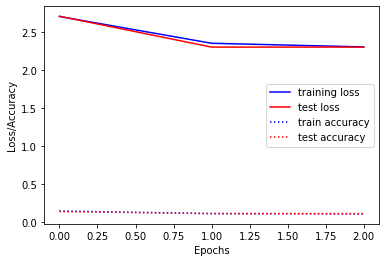

In [18]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

## ADJUSTING HYPERPARAMETERS

Observation is done by changing only one particular parameter, and having the remaining parameters the same as followings:

```
learning_rate = 0.1
n_unit = 256
batch_size = 32
```



### 1) Reducing layer size to from 256 to 32 neurons

In [ ]:
num_epochs = 10
learning_rate = 0.1
batch_size = 32
n_unit = 32 # from 256 to 32 units

model = MyModel(n_unit)
(train_ds, test_ds), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True,
)

train_losses , train_accuracies , test_losses , test_accuracies = [], [], [], []

train_losses, train_accuracies, test_losses ,test_accuracies = train(
    model = model, 
    train_ds= prepare_mnist_data(train_ds, batch_size), 
    test_ds= prepare_mnist_data(test_ds, batch_size), 
    epochs= num_epochs, 
    loss_function= tf.keras.losses.CategoricalCrossentropy(), 
    optimizer = tf.keras.optimizers.SGD(learning_rate),
    train_losses=train_losses,
    train_accuracies=train_accuracies,
    test_losses=test_losses,
    test_accuracies=test_accuracies
)
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

**Observation:**



### 2) Increasing batch size from 32 to 64

In [ ]:
num_epochs = 10
learning_rate = 0.1
batch_size = 64 # from 32 to 64 units
n_unit = 256 

model = MyModel(n_unit)
(train_ds, test_ds), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True,
)

train_losses , train_accuracies , test_losses , test_accuracies = [], [], [], []

train_losses, train_accuracies, test_losses ,test_accuracies = train(
    model = model, 
    train_ds= prepare_mnist_data(train_ds, batch_size), 
    test_ds= prepare_mnist_data(test_ds, batch_size), 
    epochs= num_epochs, 
    loss_function= tf.keras.losses.CategoricalCrossentropy(), 
    optimizer = tf.keras.optimizers.SGD(learning_rate),
    train_losses=train_losses,
    train_accuracies=train_accuracies,
    test_losses=test_losses,
    test_accuracies=test_accuracies
)
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

**Observation:**



### 3) Increasing learning rate from 0.1 to 0.2

In [ ]:
num_epochs = 10
learning_rate = 0.2  # from 0.1 to 0.2
batch_size = 32
n_unit = 256

model = MyModel(n_unit)
(train_ds, test_ds), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True,
)

train_losses , train_accuracies , test_losses , test_accuracies = [], [], [], []

train_losses, train_accuracies, test_losses ,test_accuracies = train(
    model = model, 
    train_ds= prepare_mnist_data(train_ds, batch_size), 
    test_ds= prepare_mnist_data(test_ds, batch_size), 
    epochs= num_epochs, 
    loss_function= tf.keras.losses.CategoricalCrossentropy(), 
    optimizer = tf.keras.optimizers.SGD(learning_rate),
    train_losses=train_losses,
    train_accuracies=train_accuracies,
    test_losses=test_losses,
    test_accuracies=test_accuracies
)

**Observation:**



### 4) Reducing 2 layers to 1 hidden layer (256 neurons)

In [ ]:
# Updating model to only 1 hidden layer

class MyModel(tf.keras.Model):
    # Define the layers of the model
    def __init__(self, n_unit):
        super(MyModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(n_unit, activation=tf.nn.relu)
        # self.dense2 = tf.keras.layers.Dense(n_unit, activation=tf.nn.relu)
        self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

    # Forward pass
    @tf.function
    def call(self, inputs):
        x = self.dense1(inputs)
        # x = self.dense2(x)
        x = self.out(x)
        return x

In [ ]:
num_epochs = 10
learning_rate = 0.1
batch_size = 32
n_unit = 32 # from 256 to 32 units

model = MyModel(n_unit)
(train_ds, test_ds), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True,
)

train_losses , train_accuracies , test_losses , test_accuracies = [], [], [], []

train_losses, train_accuracies, test_losses ,test_accuracies = train(
    model = model, 
    train_ds= prepare_mnist_data(train_ds, batch_size), 
    test_ds= prepare_mnist_data(test_ds, batch_size), 
    epochs= num_epochs, 
    loss_function= tf.keras.losses.CategoricalCrossentropy(), 
    optimizer = tf.keras.optimizers.SGD(learning_rate),
    train_losses=train_losses,
    train_accuracies=train_accuracies,
    test_losses=test_losses,
    test_accuracies=test_accuracies
)
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

**Observation:**

